In [1]:
using Distributions 
using IntervalSets
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Random123
using HCubature
using HDF5

using KDTree
using BAT
using BATPar

using LaTeXStrings

┌ Info: Precompiling KDTree [696f4745-383f-4cfb-8be8-c7582de6cd01]
└ @ Base loading.jl:1260


In [2]:
using PyPlot

plt = PyPlot

SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = vcat([0 0 0 0], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:]);
# colors = vcat([0 0 0 0.1], plt.cm.Blues(range(0, stop=1, length=10))[3:end,:])

# Density Functions 

### Function #1: 

In [ ]:
sigma_1 = [0.32716446841097613 0.17276467616026275; 0.17276467616026275 0.33056237691918017]
sigma_2 = [0.15152028283087893 -0.11598742336072133; -0.11598742336072133 0.1616797732933265] #[0.1572026439007445 -0.1044956058704804; -0.1044956058704804 0.13445945463874312] 
sigma_3 = [0.01942201849281335 -0.003187584896683795; -0.003187584896683795 0.017175237584791444]

N = 2 
min_v = -20
max_v = 20
lgV = N*log(max_v-min_v); 

f(x;μ=[0, 0], sigma=sigma) = pdf(MvNormal(μ, sigma), x)

g(x) = (1/3)*(f(x, μ=[4, 4], sigma=sigma_1) + f(x, μ=[-4, -4], sigma=sigma_1) + 0.1*f(x, μ=[4.5, -4.5], sigma=sigma_3) + 0.9*f(x, μ=[-4.5, 4.5], sigma=sigma_2))

### Function #2:

In [ ]:
g(x;) = prod(pdf.(Normal(), x))

N = 2 
min_v = -10
max_v = 10
lgV = N*log(max_v-min_v); 

### Function #3:

In [ ]:
f(x;μ=[0, 0], sigma=[1,1]) = pdf(Normal(μ[1], sigma[1]), x[1])*pdf(Normal(μ[2], sigma[2]), x[2])

g(x) = 0.5*(f(x, μ=[-30, 1], sigma=[1,1]) + f(x, μ=[30, 1], sigma=[1,1]) )

N = 2 
min_v = -50
max_v = 50
lgV = N*log(max_v-min_v); 

### Function #4: 

In [3]:
# Report Example:

sigma_1 = [0.32716446841097613 0.17276467616026275; 0.17276467616026275 0.33056237691918017]
sigma_3 = [0.01942201849281335 -0.003187584896683795; -0.003187584896683795 0.017175237584791444]

N = 2 
min_v = -20.
max_v = 20.
lgV = N*log(max_v-min_v); 

f(x;μ=[0, 0], sigma=sigma_1) = pdf(MvNormal(μ, sigma), x)

g(x) = (1/2.08)*(f(x, μ=[3.5, 3.5], sigma=sigma_1) + f(x, μ=[-3.5, -3.5], sigma=sigma_1) + 0.04*f(x, μ=[3.5, -3.5], sigma=sigma_3) + 0.04*f(x, μ=[-3.5, 3.5], sigma=sigma_3))

g (generic function with 1 method)

# Serial Sampling 

In [4]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.65..0.75,
    β = 1.5,
    c = 1e-4..1e4
)


# * `λ`: Controls the weight given to new covariance information in adapting
#   the proposal distribution. Defaults to `0.5`.

# * `α`: Metropolis-Hastings acceptance ratio target, tuning will try to
#   adapt the proposal distribution to bring the acceptance ratio inside this
#   interval. Defaults to `IntervalSets.ClosedInterval(0.15, 0.35)`

# * `β`: Controls how much the spread of the proposal distribution is
#   widened/narrowed depending on the current MH acceptance ratio.

# * `c`: Interval for allowed scale/spread of the proposal distribution.
#   Defaults to `ClosedInterval(1e-4, 1e2)`.

# * `r`: Reweighting factor. Take accumulated sample statistics of previous
#   tuning cycles into account with a relative weight of `r`. Set to `0` to
#   completely reset sample statistics between each tuning cycle.


convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 20..1000,
    max_nsamples_init = 1000,
    max_nsteps_init = 1000,
    max_time_init = 18
)

# `init_tries_per_chain`: Interval that specifies the minimum and maximum
#   number of tries per MCMC chain to find a suitable starting position. Many
#   candidate chains will be created and run for a short time. The chains with
#   the best performance will be selected for tuning/burn-in and MCMC sampling
#   run. Defaults to `IntervalSets.ClosedInterval(8, 128)`.

# * `max_nsamples_init`: Maximum number of MCMC samples for each candidate
#   chain. Defaults to 25. Definition of a sample depends on sampling algorithm.

# * `max_nsteps_init`: Maximum number of MCMC steps for each candidate chain.
#   Defaults to 250. Definition of a step depends on sampling algorithm.

# * `max_time_init::Int`: Maximum wall-clock time to spend per candidate chain,
#   in seconds. Defaults to `Inf`.

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = 25,
    max_ncycles = 0
)

# * `max_nsamples_per_cycle`: Maximum number of MCMC samples to generate per
#   cycle, defaults to `1000`. Definition of a sample depends on MCMC algorithm.

# * `max_nsteps_per_cycle`: Maximum number of MCMC steps per cycle, defaults
#   to `10000`. Definition of a step depends on MCMC algorithm.

# * `max_time_per_cycle`: Maximum wall-clock time to spend per cycle, in
#   seconds. Defaults to `Inf`.

# * `max_ncycles`: Maximum number of cycles.


MCMCBurninStrategy
  max_nsamples_per_cycle: Int64 4000
  max_nsteps_per_cycle: Int64 4000
  max_time_per_cycle: Float64 25.0
  max_ncycles: Int64 0


In [5]:
likelihood = params -> LogDVal((log(g(params.a))))
prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],);
posterior = PosteriorDensity(likelihood, prior);

Compare theoretical distribution and samples:

## Serial MCMC over whole parameter space:

In [6]:
samples_tmp, stats_tmp = bat_sample(posterior, (1*10^4, 2), MetropolisHastings());
samples_t = flatview(unshaped.(samples_tmp.v));

┌ Info: Trying to generate 2 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 2 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 2 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 2 chains, 0 tuned, 2 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 2 chains, 0 tuned, 2 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 2 chains, 0 tuned, 2 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 2 chains, 0 tuned, 2 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.

In [7]:
# save samples if needed: 

# outp = bat_read("samples_for_correlation_ahmi_error.hdf5")
# full_space_samples = varshape(prior).(outp);

# bat_write("samples_1.hdf5", unshaped.(samples_tmp))

### Truth vs. sampling:

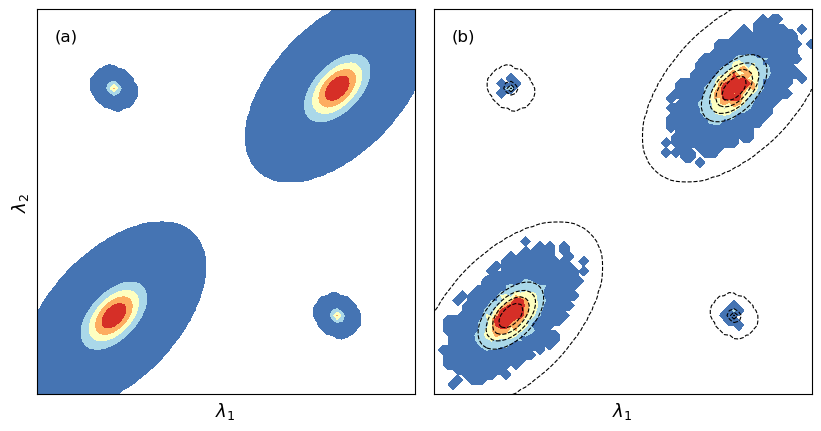

In [8]:
# x_range = range(minimum(samples_t[1,:]), stop=maximum(samples_t[1,:]), length=80)
# y_range = range(minimum(samples_t[2,:]), stop=maximum(samples_t[2,:]), length=80)

x_range = range(-6, stop=6, length=80)
y_range = range(-6, stop=6, length=80)

z = [g([i,j]) for i in midpoints(x_range), j in midpoints(y_range)]';

histogram_2D_o = fit(Histogram, (samples_t[1,:],samples_t[2,:]), weights(samples_tmp.weight), (x_range, y_range))
histogram_2D_o = normalize(histogram_2D_o, mode=:pdf)

min_color=minimum([minimum(histogram_2D_o.weights), minimum(z)])
maximum_color= maximum(z)

levels=range(1e-6, maximum_color, length=6)

# levels_quantiles = [ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.971, 0.981, 0.988, 0.99, 0.999, 1,]
# levels=quantile(sort([z[z.>0.0000001]...]), levels_quantiles)

fig, ax = plt.subplots(1,2,figsize=(10, 5),)
fig.subplots_adjust(wspace=0.05)

ax[1].contourf(midpoints(x_range), midpoints(y_range), z, cmap="RdYlBu_r", levels=levels)
ax[1].text(-5,5.1,"(a)",horizontalalignment="center", verticalalignment="center")
ax[2].contourf(midpoints(x_range), midpoints(y_range), replace( x-> x>maximum_color ? maximum_color : x, histogram_2D_o.weights'), cmap="RdYlBu_r", levels=levels) 
ax[2].contour(midpoints(x_range), midpoints(y_range), z, linewidths=0.8, linestyles="--", levels=levels, colors="black", )
ax[2].text(-5,5.1,"(b)",horizontalalignment="center", verticalalignment="center")

ax[1].set_yticks([])
ax[1].set_xticks([])
 
ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"\lambda_2")

# ax[2].set_yticks([])
ax[2].set_xticks([])

ax[2].set_xlabel(L"\lambda_1")
ax[2].get_yaxis().set_visible(false) 


# fig.savefig("../../MCMC_publication/fig-a.png", bbox_inches = "tight", dpi=500)

# fig.colorbar(cs1)
# fig.colorbar(cs2)

## Exploration samples: 

In [9]:
nnsamples = 450
nnchains = 75

samples, stats = bat_sample(posterior, (nnsamples, nnchains), MetropolisHastings(), burnin=burnin);

smpl = flatview(unshaped.(samples.v))
weights_LogLik = samples.logd
weights_Histogram = samples.weight;


┌ Info: Trying to generate 75 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 75 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 75 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Warning: MCMC tuning of 75 chains aborted after 0 cycle(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:115


In [10]:
data_kdtree = Data(smpl[:,1:5:end], weights_Histogram[1:5:end], weights_LogLik[1:5:end]);

# Space Partitioning

In [11]:
KDTree.evaluate_total_cost(data::Data) = KDTree.cost_f_1(data)

output, cost_array = DefineKDTree(data_kdtree, [1,2,], 15);

extend_tree_bounds!(output, [min_v, min_v], [max_v, max_v])

┌ Info: KDTree: Increasing tree depth: depth = 1
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 2
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 3
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 4
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 5
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 6
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 7
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: depth = 8
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:186
┌ Info: KDTree: Increasing tree depth: d

### Space partitionign: 

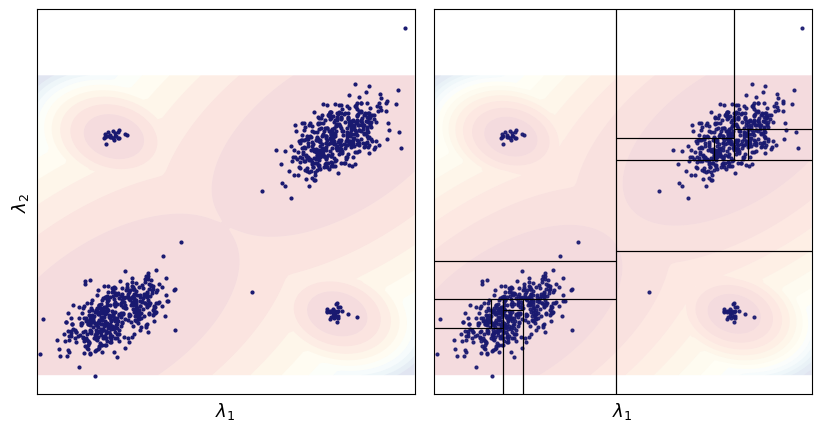

PyObject <matplotlib.patches.Rectangle object at 0x1907c1e90>

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.05)

ax[1].contourf(midpoints(x_range), midpoints(y_range), log.(z), cmap="RdYlBu_r", levels=10, alpha=0.15, antialiased =true)
ax[1].scatter(smpl[1,:], smpl[2,:], color="midnightblue", s=4)

ax[1].set_yticks([])
ax[1].set_xticks([])
 
ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"\lambda_2")

ax[2].contourf(midpoints(x_range), midpoints(y_range), log.(z), cmap="RdYlBu_r", levels=15, alpha=0.15, antialiased =true)
ax[2].scatter(smpl[1,:], smpl[2,:], color="midnightblue", s=4, alpha=0.9) #color=get_cmap("tab10", 1) | ColorMap("tab10").colors[1]

ax[2].get_yaxis().set_visible(false) 
ax[2].set_xticks([])
ax[2].set_xlabel(L"\lambda_1")

plot_tree(output, [1,2], ax[2], color="black", linewidth=0.8)

# ax.set_xlim(-11., 11.)
# ax.set_ylim(-11., 11.)

# fig.savefig("../../MCMC_publication/fig-b.pdf", bbox_inches = "tight")

# Sampling of subspaces 

In [13]:
bounds_part = extract_par_bounds(output)

BATPar.make_named_prior(i) = BAT.NamedTupleDist( a = [i[1,1]..i[1,2], i[2,1]..i[2,2]])

nnsamples = 10^4
nnchains = 5

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.45,
    β = 1.5,
    c = 1e-4..1e2
)

algorithm = MetropolisHastings();

samples_parallel = bat_sample_parallel(likelihood, bounds_part, (nnsamples, nnchains), algorithm, tuning=tuning);

┌ Info: BATPar: Sampling subspace 1:
└ @ BATPar /Users/vhafych/MPP-Server/gitrepos/BATPar.jl/src/BATPar.jl:82
┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 3 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 5 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 5 chains success

In [14]:
smpl_par = hcat(samples_parallel.samples...)
x = smpl_par[1,:]
y = smpl_par[2,:]
w_o = samples_parallel.weights_o
w_r =  samples_parallel.weights_r;

In [15]:
sum(w_r)

0.9986800789687006

In [16]:
sum(samples_parallel.weights_r)

0.9986800789687006

In [17]:
sqrt(sum((samples_parallel.uncertainty).^2))

0.0013571081596536892

#### 2D histogram:

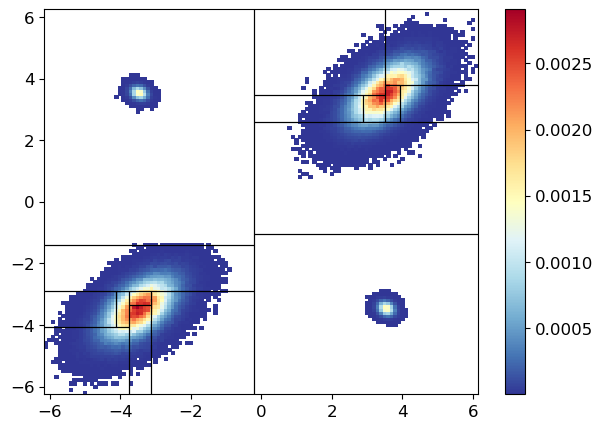

PyObject <matplotlib.patches.Rectangle object at 0x187d05f10>

In [18]:
histogram_2D_r = fit(Histogram, (x,y), weights(w_r), nbins=200)
histogram_2D_r = normalize(histogram_2D_r, mode=:probability)

# colors = vcat([0 0 0 0], plt.cm.YlOrBr(range(0, stop=1, length=10))[2:end,:])
# colors = vcat([0 0 0 0.09], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:]) # very good

fig, ax = plt.subplots(1,1, figsize=(7, 5))

img = ax.pcolormesh(midpoints(histogram_2D_r.edges[1]), midpoints(histogram_2D_r.edges[2]), replace(histogram_2D_r.weights', 0=>NaN), cmap="RdYlBu_r") #terrain_r  vmin = -0.0001, vmax=maximum_v,
#cmap="RdYlBu_r", cmap=ColorMap(colors)
fig.colorbar(img)

plot_tree(output, [1,2], ax, linewidth=0.8, color="black", alpha=1)

#### Corner plot: 

In [19]:
function corner_plots(samples::AbstractArray, tree::Node, sample_weights_r::AbstractArray, sample_weights_o::AbstractArray, dim_indices::AbstractArray, dim_names::AbstractArray;
        save_plot=false,
        FILE_NAME = "density_function.pdf",
        N_bins = 100,
        levels_quantiles = [0.4, 0.7, 0.8, 0.9, 0.99, 1,], 
        hist_color = plt.cm.tab10(1), 
        colors = vcat([0 0 0 0.3], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:]),  #vcat([1 1 1 1], plt.cm.Blues(range(0, stop=1, length=20))[2:end,:]),
        kwargs...,
    )
    
    N = length(dim_indices)
    bins=[]
    fig, ax = plt.subplots(N,N, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
    for idx in 1:N
        dim_idx = dim_indices[idx]
        bins_tmp = range(minimum(samples[dim_idx,:]), stop=maximum(samples[dim_idx,:]), length=N_bins)
        push!(bins, bins_tmp)
#         ax[idx, idx].hist(samples[dim_idx,:], weights=sample_weights_o/sum(sample_weights_o), bins=bins_tmp, color=hist_color, alpha=0.4)
        ax[idx, idx].hist(samples[dim_idx,:], weights=sample_weights_r/sum(sample_weights_r), bins=bins_tmp,  color="lightgray", alpha=1, linewidth=0.9) #histtype="step",
        ax[idx, idx].set_xlim(first(bins_tmp),last(bins_tmp))
    end
    
    for i in 2:N, j in 1:(i-1)
        
        dim_x = dim_indices[j]
        dim_y = dim_indices[i]
        
        histogram_2D_r = fit(Histogram, (samples[dim_x,:],samples[dim_y,:]), weights(sample_weights_r), (bins[j], bins[i]))
        histogram_2D_r = normalize(histogram_2D_r, mode=:probability)
        
        histogram_2D_o = fit(Histogram, (samples[dim_y,:],samples[dim_x,:]), weights(sample_weights_o), (bins[i], bins[j]))
        histogram_2D_o = normalize(histogram_2D_o, mode=:probability)
        
        levels=quantile([histogram_2D_r.weights...], levels_quantiles)
        
        ax[i,j].pcolormesh(midpoints(histogram_2D_r.edges[1]), midpoints(histogram_2D_r.edges[2]), replace(histogram_2D_r.weights', 0=>NaN), cmap="RdYlBu_r" , ) #bottom | ColorMap(colors) "RdYlBu_r"
        ax[i,j].set_xlim(first(bins[j]),last(bins[j]))
        ax[i,j].set_ylim(first(bins[i]),last(bins[i]))
        
        min_v_2 = minimum(histogram_2D_o.weights[histogram_2D_o.weights .> 0])
        ax[j,i].pcolormesh(midpoints(histogram_2D_o.edges[1]), midpoints(histogram_2D_o.edges[2]), replace(histogram_2D_o.weights', 0=>NaN),  cmap="RdYlBu_r" ,) # top
        plot_tree(tree, [dim_y,dim_x], ax[j,i]; kwargs...,)
        
        ax[j,i].set_xlim(first(bins[i]),last(bins[i]))
        ax[j,i].set_ylim(first(bins[j]),last(bins[j]))
        
        
    end
    
    for i in 1:N, j in 1:N
        if 1<i<N 
            ax[i,j].get_xaxis().set_visible(false)
        elseif i==1 
            ax[i,j].xaxis.tick_top()
            ax[i,j].xaxis.set_label_position("top")
            ax[i,j].set_xlabel(dim_names[j])
        else
            ax[i,j].set_xlabel(dim_names[j]) 
        end
        
        if j == i || N>j>1
            # nothing inside 
            ax[i,j].get_yaxis().set_visible(false) 
        elseif j==N
            # right labels
            ax[i,j].set_ylabel(dim_names[i])
            ax[i,j].yaxis.set_label_position("right")
            ax[i,j].yaxis.tick_right()
        else
            #left labels
            ax[i,j].set_ylabel(dim_names[i])
        end
    end
    
    if save_plot 
        fig.savefig(FILE_NAME, bbox_inches = "tight")
    end
        
end

corner_plots (generic function with 1 method)

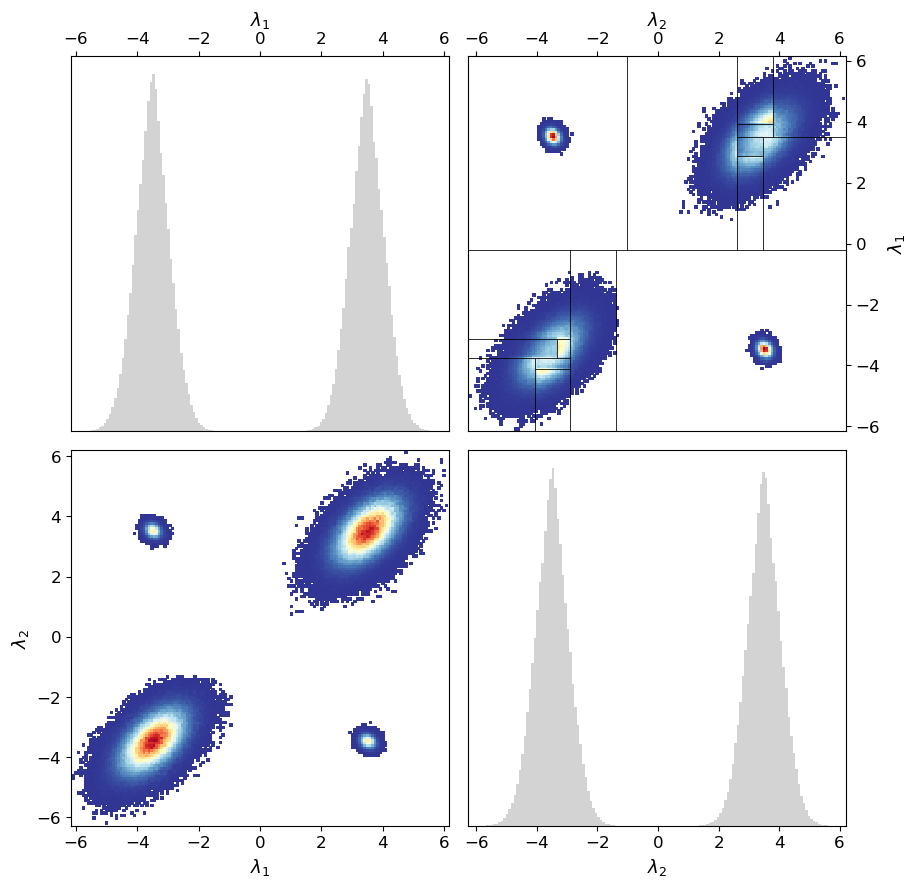

In [20]:
corner_plots(smpl_par, output, w_r, w_o, [1,2,], [L"\lambda_1", L"\lambda_2", L"\lambda_3", L"\lambda_4"], N_bins=150; color="black", linewidth=0.4)

#### Comparison #1

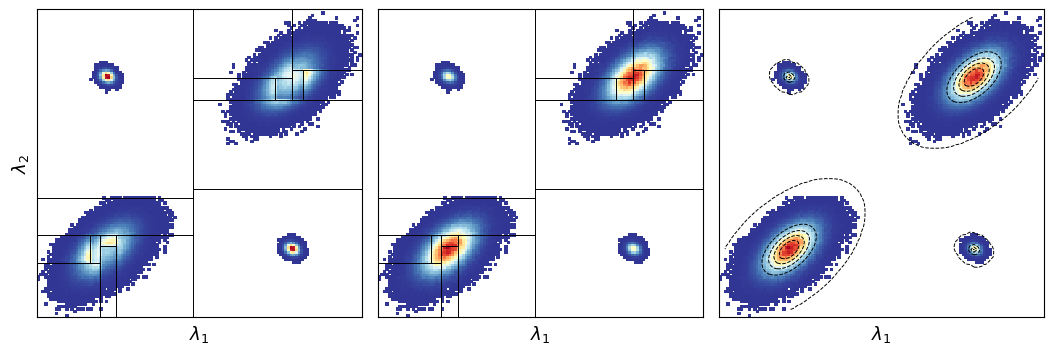

PyObject Text(0.5, 31.0, '$\\lambda_1$')

In [21]:
histogram_2D_wo = fit(Histogram, (x,y), weights(w_o), nbins=200)
histogram_2D_wo = normalize(histogram_2D_wo, mode=:pdf)

histogram_2D_wr = fit(Histogram, (x,y), weights(w_r), nbins=200)
histogram_2D_wr = normalize(histogram_2D_wr, mode=:pdf)

# colors = vcat([0 0 0 0], plt.cm.YlOrBr(range(0, stop=1, length=10))[2:end,:])
# colors = vcat([0 0 0 0.09], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:]) # very good

fig, ax = plt.subplots(1,3, figsize=(13, 4))
fig.subplots_adjust(wspace=0.05)

ax[1].pcolormesh(midpoints(histogram_2D_wo.edges[1]), midpoints(histogram_2D_wo.edges[2]), replace(histogram_2D_wo.weights', 0=>NaN), cmap="RdYlBu_r") 

ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"\lambda_2")

plot_tree(output, [1,2], ax[1], linewidth=0.6, color="black", alpha=1)

ax[2].pcolormesh(midpoints(histogram_2D_wr.edges[1]), midpoints(histogram_2D_wr.edges[2]), replace(histogram_2D_wr.weights', 0=>NaN), cmap="RdYlBu_r") 

ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_xlabel(L"\lambda_1")

plot_tree(output, [1,2], ax[2], linewidth=0.6, color="black", alpha=1)

ax[3].pcolormesh(midpoints(histogram_2D_wr.edges[1]), midpoints(histogram_2D_wr.edges[2]), replace(histogram_2D_wr.weights', 0=>NaN), cmap="RdYlBu_r") 
ax[3].contour(midpoints(x_range), midpoints(y_range), z, linewidths=0.7, linestyles="--", levels=levels, colors="black", )
ax[3].set_yticks([])
ax[3].set_xticks([])
ax[3].set_xlabel(L"\lambda_1")

# fig.savefig("../../MCMC_publication/fig-c.pdf", bbox_inches = "tight")

#### Comparison #2

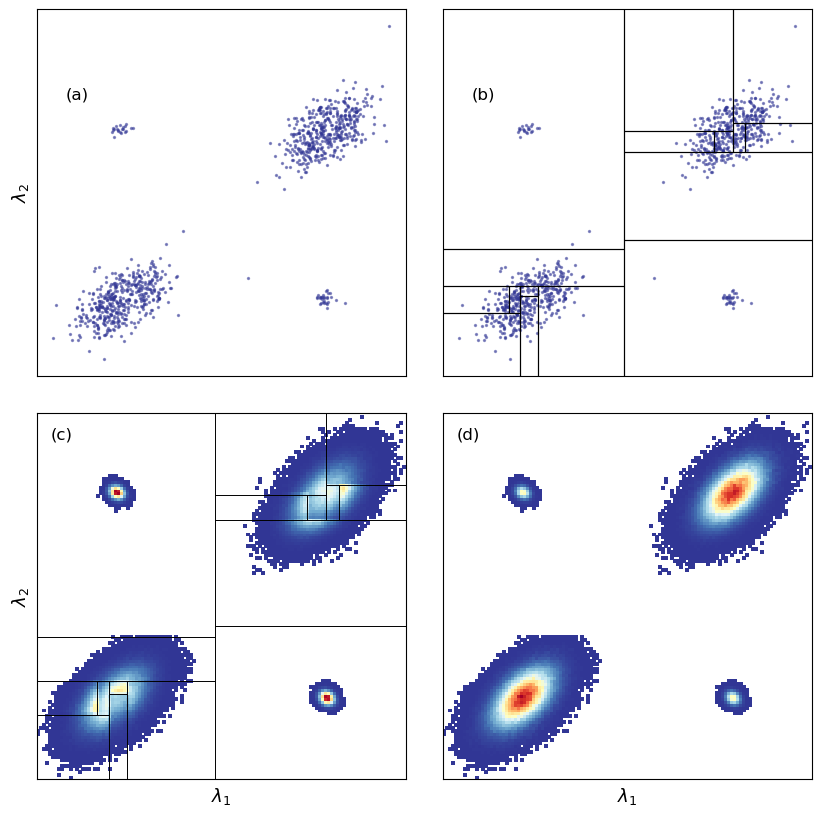

PyObject Text(31.0, 0.5, '$\\lambda_2$')

In [22]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# ax[1,1].contourf(midpoints(x_range), midpoints(y_range), log.(z), cmap="RdYlBu_r", levels=10, alpha=0.15, antialiased =true)
ax[1,1].scatter(smpl[1,:], smpl[2,:], color=PyPlot.cm.RdYlBu_r(0,0,), s=2, alpha=0.5) #midnightblue

ax[1,1].text(-5.0,5.0,"(a)",horizontalalignment="center", verticalalignment="center")
# ax[1,2].contourf(midpoints(x_range), midpoints(y_range), log.(z), cmap="RdYlBu_r", levels=15, alpha=0.15, antialiased =true)
ax[1,2].scatter(smpl[1,:], smpl[2,:], color=PyPlot.cm.RdYlBu_r(0,0,), s=2, alpha=0.5) #color=get_cmap("tab10", 1) | ColorMap("tab10").colors[1]
ax[1,2].text(-5,5,"(b)",horizontalalignment="center", verticalalignment="center")
plot_tree(output, [1,2], ax[1,2], color="black", linewidth=0.8)

ax[2, 1].pcolormesh(midpoints(histogram_2D_wo.edges[1]), midpoints(histogram_2D_wo.edges[2]), replace(histogram_2D_wo.weights', 0=>NaN), cmap="RdYlBu_r", rasterized=true) 
plot_tree(output, [1,2], ax[2, 1], linewidth=0.6, color="black", alpha=1)
ax[2,1].text(-5.3,5.5,"(c)",horizontalalignment="center", verticalalignment="center")

ax[2,2].pcolormesh(midpoints(histogram_2D_wr.edges[1]), midpoints(histogram_2D_wr.edges[2]), replace(histogram_2D_wr.weights', 0=>NaN), cmap="RdYlBu_r", rasterized=true) 
ax[2,2].text(-5.3,5.5,"(d)",horizontalalignment="center", verticalalignment="center")

ax[1,1].get_xaxis().set_visible(false)
ax[1,2].get_xaxis().set_visible(false)
ax[1,2].get_yaxis().set_visible(false)
ax[2,2].get_yaxis().set_visible(false)

ax[2,2].set_xticks([])
ax[2,2].set_xlabel(L"\lambda_1")

ax[2,1].set_xticks([])
ax[2,1].set_xlabel(L"\lambda_1")

ax[1,1].set_yticks([])
ax[1,1].set_ylabel(L"\lambda_2")

ax[2,1].set_yticks([])
ax[2,1].set_ylabel(L"\lambda_2")

# fig.savefig("../../MCMC_publication/fig-d.png", bbox_inches = "tight", dpi=500)

#### Comparison #3

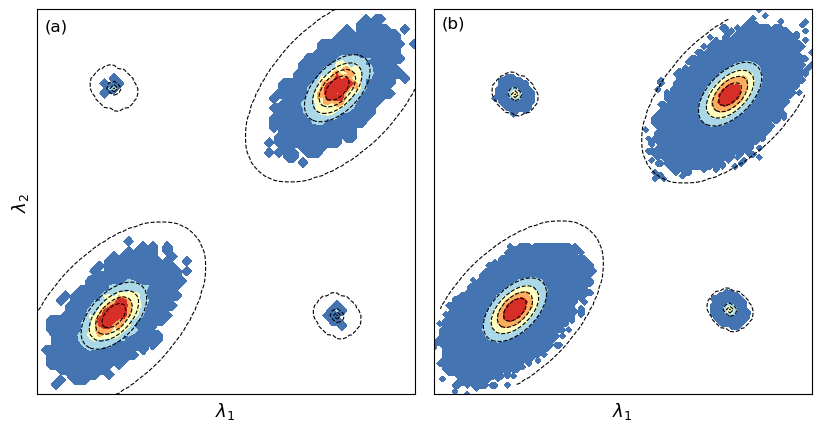

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.05)

ax[2].contourf(midpoints(histogram_2D_wr.edges[1]), midpoints(histogram_2D_wr.edges[2]), replace( x-> x>maximum_color ? maximum_color : x, histogram_2D_wr.weights'), cmap="RdYlBu_r", levels=levels)
ax[2].contour(midpoints(x_range), midpoints(y_range), z, linewidths=0.8, linestyles="--", levels=levels, colors="black", )
ax[1].text(-5.3,5.4,"(a)",horizontalalignment="center", verticalalignment="center")
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"\lambda_2")


ax[1].contourf(midpoints(x_range), midpoints(y_range), replace( x-> x>maximum_color ? maximum_color : x, histogram_2D_o.weights'), cmap="RdYlBu_r", levels=levels) 
ax[1].contour(midpoints(x_range), midpoints(y_range), z, linewidths=0.8, linestyles="--", levels=levels, colors="black", )
ax[2].text(-5.5,5.8,"(b)",horizontalalignment="center", verticalalignment="center")
ax[2].set_xticks([])
ax[2].set_xlabel(L"\lambda_1")
ax[2].get_yaxis().set_visible(false) 

# fig.savefig("../../MCMC_publication/fig-e.png", bbox_inches = "tight", dpi=500)

#### Comparison #4

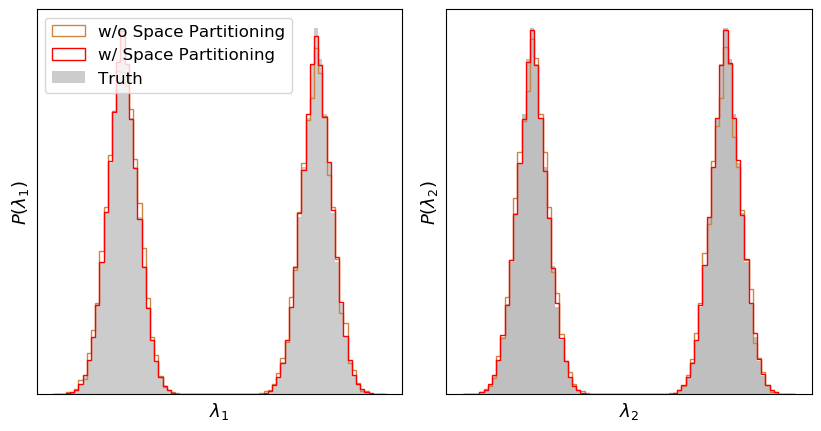

PyObject <matplotlib.legend.Legend object at 0x1a189ee90>

In [24]:
bar_width = diff(x_range)[1];
bar_height_1 = [sum(z, dims=1)...];
bar_height_2 = [sum(z, dims=1)...];

fig, ax = plt.subplots(1,2,figsize=(10, 5),)
fig.subplots_adjust(wspace=0.12)

ax[1].bar(midpoints(x_range), bar_height_1.*bar_width, width=bar_width, alpha=0.4, color="gray", label="Truth")
# ax[1].step(midpoints(x_range), bar_height_1.*bar_width, where="mid", alpha=1, color="red", )
ax[1].hist(samples_t[1,:], weights=weights(samples_tmp.weight), bins=x_range, density=true, alpha=1, histtype="step", color="peru", label="w/o Space Partitioning")
ax[1].hist(x, weights=w_r, bins=x_range, density=true, alpha=1,  histtype="step", color="red", label="w/ Space Partitioning")

ax[2].bar(midpoints(y_range), bar_height_2.*bar_width, width=bar_width, alpha=0.5, color="gray", label="Truth")
ax[2].hist(samples_t[2,:], weights=weights(samples_tmp.weight), bins=x_range, density=true, alpha=1, histtype="step", color="peru")
ax[2].hist(y, weights=w_r, bins=x_range, density=true, histtype="step", color="red")

ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel(L"\lambda_2")
ax[2].set_ylabel(L"P(\lambda_2)")

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"P(\lambda_1)")

ax[1].legend(loc="upper left", frameon=true, framealpha=0.8, ncol=1)

# fig.savefig("../../MCMC_publication/fig-g.pdf", bbox_inches = "tight")